# Mesonet Testing

This notebook derives ET values from the created data product and compares them with the existing Mesonet Stations and their PM-derived ET.

In [1]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
import os
from os import listdir
from os.path import join

import time
import random
import itertools
from datetime import datetime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from src.PM_eq import penman_monteith

In [3]:
fluxes = pd.read_csv('../data_v02/validation/validation_dataset.csv')
fluxes['TIMESTAMP'] = pd.to_datetime(fluxes.TIMESTAMP, format='%Y-%m-%d')
fluxes.rename(columns={"TIMESTAMP": "date"}, inplace=True)
fluxes.ETos_daily_in *= 25.4
fluxes.ETrs_daily_in *= 25.4

fluxes

,date,ETos_daily_in,ETrs_daily_in,site,lat,lon
0,2019-01-01,0.1778,0.2286,Becker,45.34399,-93.85014
1,2019-01-02,0.3302,0.4826,Becker,45.34399,-93.85014
2,2019-01-03,0.5842,0.8382,Becker,45.34399,-93.85014
3,2019-01-04,0.6096,0.7874,Becker,45.34399,-93.85014
4,2019-01-05,0.6350,0.9144,Becker,45.34399,-93.85014
...,...,...,...,...,...,...
18278,2022-12-27,0.3302,0.4572,Westport,45.71509,-95.17179
18279,2022-12-28,0.2286,0.2540,Westport,45.71509,-95.17179
18280,2022-12-29,0.1016,0.1016,Westport,45.71509,-95.17179
18281,2022-12-30,0.2794,0.3302,Westport,45.71509,-95.17179


# Deriving ET from the data product

In [5]:
path = '/home/runck014/shared/et_upscaling/ET_new'
files = listdir(path)
D = {site: {'date': [], 'site': [], 'ET': []} for site in fluxes.site.unique()}
for f in files:
    data = xr.open_dataset(join(path, f))
    for site in fluxes.site.unique():
        lat, lon = fluxes[fluxes.site==site].lat.iloc[0].item(), fluxes[fluxes.site==site].lon.iloc[0].item()
        ET = data.sel(x=lon, y=lat, method='pad')['et'].values
        dates = data.sel(x=lon, y=lat, method='pad').date.values
        
        D[site]['date'].append(dates)
        D[site]['site'].append([site]*len(dates))
        D[site]['ET'].append(ET)

In [6]:
for site in fluxes.site.unique():
    D[site]['date'] = np.concatenate(D[site]['date'])
    D[site]['site'] = np.concatenate(D[site]['site'])
    D[site]['ET'] = np.concatenate(D[site]['ET'])

In [7]:
dfs = []
for site in fluxes.site.unique():
    dfs.append(pd.DataFrame(D[site]))
ETs = pd.concat(dfs, axis=0)
ETs.to_csv('../data_v02/validation/validation_preds.csv', index=None)

# Comparison

In [8]:
openet = pd.read_csv('../data_v02/validation/OpenET_validation.csv').rename(columns={'dates': 'date', 'ET': 'OpenET'})
openet.date = pd.to_datetime(openet.date)
openet

,date,site,OpenET
0,2019-01-31,Becker,2
1,2019-02-28,Becker,4
2,2019-03-31,Becker,24
3,2019-04-30,Becker,53
4,2019-05-31,Becker,62
...,...,...,...
931,2024-08-31,Westport,98
932,2024-09-30,Westport,74
933,2024-10-31,Westport,35
934,2024-11-30,Westport,8


In [9]:
df = fluxes.merge(ETs, on=['date', 'site'], how='left')
df.ET = df.ET.interpolate()
df

,date,ETos_daily_in,ETrs_daily_in,site,lat,lon,ET
0,2019-01-01,0.1778,0.2286,Becker,45.34399,-93.85014,0.139241
1,2019-01-02,0.3302,0.4826,Becker,45.34399,-93.85014,0.088812
2,2019-01-03,0.5842,0.8382,Becker,45.34399,-93.85014,0.100400
3,2019-01-04,0.6096,0.7874,Becker,45.34399,-93.85014,0.119785
4,2019-01-05,0.6350,0.9144,Becker,45.34399,-93.85014,0.123831
...,...,...,...,...,...,...,...
18278,2022-12-27,0.3302,0.4572,Westport,45.71509,-95.17179,0.022000
18279,2022-12-28,0.2286,0.2540,Westport,45.71509,-95.17179,0.030789
18280,2022-12-29,0.1016,0.1016,Westport,45.71509,-95.17179,0.048098
18281,2022-12-30,0.2794,0.3302,Westport,45.71509,-95.17179,0.051037


In [10]:
dfs = []
for site in df.site.unique():
    sub_df = df[df.site==site]
    sub_df = sub_df.set_index('date')[['ETos_daily_in', 'ETrs_daily_in', 'ET']].resample('M').sum().reset_index()
    sub_df.date = sub_df.date.dt.to_period('M').astype(str)
    
    sub_openet = openet[openet.site==site]
    sub_openet.date = sub_openet.date.dt.to_period('M').astype(str)
    sub_df = sub_df.merge(sub_openet, on=['date'], how='left')
    
    dfs.append(sub_df)
summary = pd.concat(dfs, axis=0)

# Visuals

In [11]:
plt.rcParams.update({'font.size': 20, 'font.family':'monospace', 'figure.figsize': (16, 9)})
full_cmap = plt.get_cmap('BrBG')
start, end = 0.7, 1.0
colors = full_cmap(np.linspace(start, end, full_cmap.N))
cmap = LinearSegmentedColormap.from_list('right_BrBG', colors)

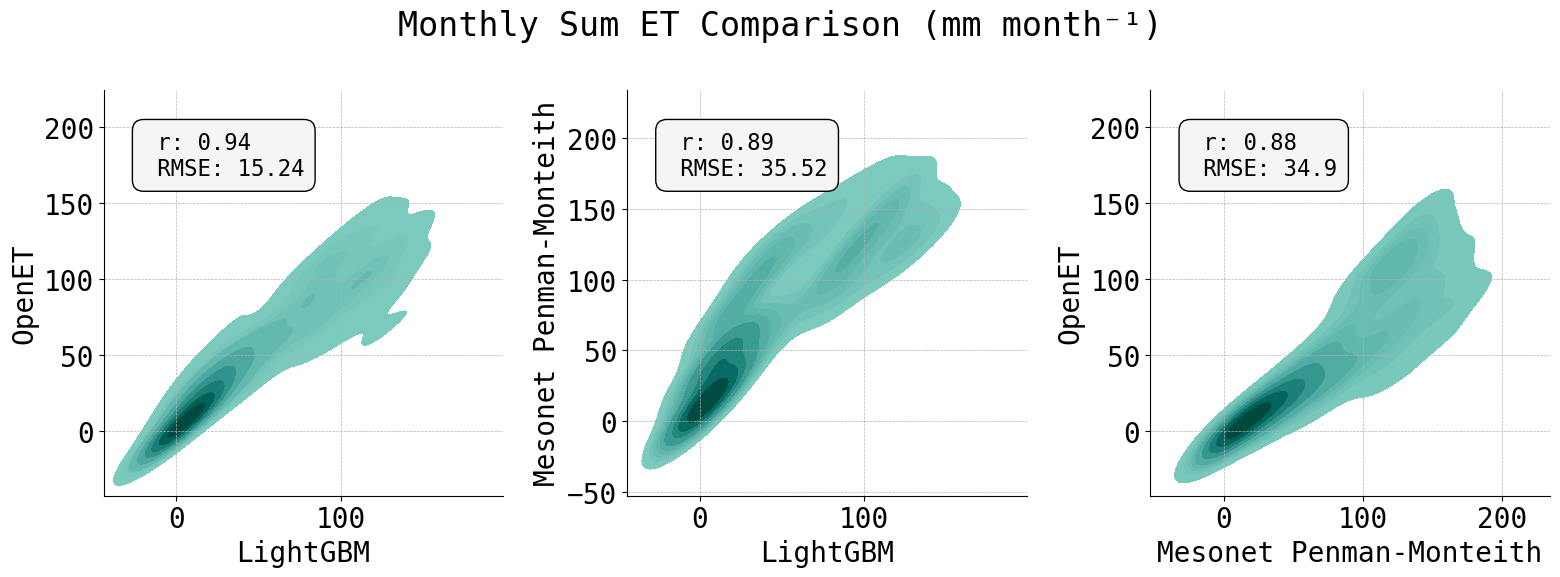

In [14]:
fig, ax = plt.subplots(1,3, figsize=(16,6))

sns.kdeplot(summary, x='ET', y='OpenET', ax=ax[0], cmap=cmap, shade=True, cbar=False)
sns.kdeplot(summary, x='ET', y='ETos_daily_in', ax=ax[1], cmap=cmap, shade=True, cbar=False)
sns.kdeplot(summary, x='ETos_daily_in', y='OpenET', ax=ax[2], cmap=cmap, shade=True, cbar=False)

for i, var in zip(range(3), [['ET', 'OpenET'], ['ET', 'ETos_daily_in'], ['ETos_daily_in', 'OpenET']]):
    r = round(np.corrcoef(summary[var[0]].values, summary[var[1]].values)[0, 1],2)
    RMSE = round(mean_squared_error(summary[var[0]], summary[var[1]])**0.5,2)
    info_text = (
        f" r: {r} \n RMSE: {RMSE}"
    )
    text = ax[i].text(0.1, 0.9, info_text, transform=ax[i].transAxes, 
                      ha='left', va='top', fontsize=16, color='black', 
    bbox=dict(facecolor='whitesmoke', edgecolor='black',boxstyle='round,pad=0.5'))
    
    ax[i].grid(True, lw=0.5, ls='--')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
    if i  in [0, 1]:
        ax[i].set_xlabel('LightGBM')
        if i==1:
            ax[i].set_ylabel('Mesonet Penman-Monteith')
    if i==2:
        ax[i].set_xlabel('Mesonet Penman-Monteith')
plt.suptitle('Monthly Sum ET Comparison (mm month\u207b\u00b9)')
plt.tight_layout()
plt.savefig('../fig/comparison.png')
plt.show()

In [15]:
len(summary.site.unique())

13